# MNIST neural network from scratch for Fashion MNIST data

#### 1. Build Fully connected layer(linear layer)

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import numpy as np 

class Linear():
    def __init__(self, in_size, out_size):
        self.W = np.random.randn(in_size, out_size) * 0.01
        self.b = np.zeros((1, out_size))
        self.params = [self.W, self.b]
        self.gradW = None
        self.gradB = None
        self.gradInput = None        

    def forward(self, X):
        self.X = X
        self.output = np.dot(X, self.W) + self.b
        return self.output

    def backward(self, nextgrad):
        self.gradW = np.dot(self.X.T, nextgrad)
        self.gradB = np.sum(nextgrad, axis=0)
        self.gradInput = np.dot(nextgrad, self.W.T)
        return self.gradInput, [self.gradW, self.gradB]

#### 2. Build Rectified Linear Activation Layer (ReLU)

In [3]:
class ReLU():
    def __init__(self):
        self.params = []
        self.gradInput = None

    def forward(self, X):
        self.output = np.maximum(X, 0)
        return self.output

    def backward(self, nextgrad):
        self.gradInput = nextgrad.copy()
        self.gradInput[self.output <=0] = 0
        return self.gradInput, []

#### 3. Define the softmax function

In [4]:
def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

#### 4. Define the Cross Entropy Loss

In [5]:
class CrossEntropy:
    def forward(self, X, y):
        self.m = y.shape[0]
        self.p = softmax(X)
        cross_entropy = -np.log(self.p[range(self.m), y]+1e-16)
        loss = np.sum(cross_entropy) / self.m
        return loss
    
    def backward(self, X, y):
        y_idx = y.argmax()        
        grad = softmax(X)
        grad[range(self.m), y] -= 1
        grad /= self.m
        return grad

#### 5. Load the fashion MNIST dataset and analyze the data

In [6]:
from keras.datasets import mnist
from keras.utils import np_utils

import keras

(trainX, trainY), (testX,testY) = keras.datasets.fashion_mnist.load_data()


trainX = trainX.reshape(60000, 784)
trainX.shape
testX = testX.reshape(10000, 784)
testX.shape


trainX = trainX / 255.0
testX = testX / 255.0

trainY.shape
testY.shape

X_train = trainX
y_train = trainY


X_val = testX
y_val = testY

Using TensorFlow backend.


(60000, 784)

(10000, 784)

(60000,)

(10000,)

#### 6. Visualize the first 10 images in the dataset and their labels

<Figure size 720x72 with 0 Axes>

(-0.5, 27.5, 27.5, -0.5)

(-0.5, 27.5, 27.5, -0.5)

(-0.5, 27.5, 27.5, -0.5)

(-0.5, 27.5, 27.5, -0.5)

(-0.5, 27.5, 27.5, -0.5)

(-0.5, 27.5, 27.5, -0.5)

(-0.5, 27.5, 27.5, -0.5)

(-0.5, 27.5, 27.5, -0.5)

(-0.5, 27.5, 27.5, -0.5)

(-0.5, 27.5, 27.5, -0.5)

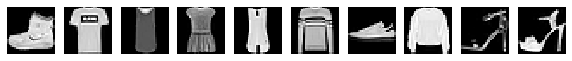

label for each of the above image: [9 0 0 3 0 2 7 2 5 5]


In [7]:
# visualizing the first 10 images in the dataset and their labels
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 1))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_train[i].reshape(28, 28), cmap="gray")
    plt.axis('off')
plt.show()
print('label for each of the above image: %s' % (y_train[0:10]))

#### Here, we define the container NN class that enables the forward prop and backward propagation of the entire network. Note, how this class enables us to add layers of different types and also correctly pass gradients using the chain rule.

In [8]:
class NN():
    def __init__(self, lossfunc=CrossEntropy(), mode='train'):
        self.params = []
        self.layers = []
        self.loss_func = lossfunc
        self.grads = []
        self.mode = mode
        
    def add_layer(self, layer):
        self.layers.append(layer)
        self.params.append(layer.params)

    def forward(self, X):
        for layer in self.layers:
            X = layer.forward(X)
        return X
    
    def backward(self, nextgrad):
        self.clear_grad_param()
        for layer in reversed(self.layers):
            nextgrad, grad = layer.backward(nextgrad)
            self.grads.append(grad)
        return self.grads
    
    def train_step(self, X, y):
        out = self.forward(X)
        loss = self.loss_func.forward(out,y)
        nextgrad = self.loss_func.backward(out,y)
        grads = self.backward(nextgrad)
        return loss, grads
    
    def predict(self, X):
        X = self.forward(X)
        p = softmax(X)
        return np.argmax(p, axis=1)
    
    def predict_scores(self, X):
        X = self.forward(X)
        p = softmax(X)
        return p
    
    def clear_grad_param(self):
        self.grads = []

#### Defining the update function (SGD with momentum)

In [9]:
def update_params(velocity, params, grads, learning_rate=0.01, mu=0.9):
    for v, p, g, in zip(velocity, params, reversed(grads)):
        for i in range(len(g)):
            v[i] = mu * v[i] - learning_rate * g[i]
            p[i] += v[i]

#### Defining a function which gives us the minibatches (both the datapoint and the corresponding label)

In [10]:
# get minibatches
def minibatch(X, y, minibatch_size):
    n = X.shape[0]
    minibatches = []
    permutation = np.random.permutation(X.shape[0])
    X = X[permutation]
    y = y[permutation]
    
    for i in range(0, n , minibatch_size):
        X_batch = X[i:i + minibatch_size, :]
        y_batch = y[i:i + minibatch_size, ]
        minibatches.append((X_batch, y_batch))
    return minibatches

#### The traning loop

In [11]:
def train(net, X_train, y_train, minibatch_size, epoch, learning_rate, mu=0.9, X_val=None, y_val=None):
    val_loss_epoch = []
    minibatches = minibatch(X_train, y_train, minibatch_size)
    minibatches_val = minibatch(X_val, y_val, minibatch_size)

    
    for i in range(epoch):
        loss_batch = []
        val_loss_batch = []
        velocity = []
        for param_layer in net.params:
            p = [np.zeros_like(param) for param in list(param_layer)]
            velocity.append(p)
            
        # iterate over mini batches
        for X_mini, y_mini in minibatches:
            loss, grads = net.train_step(X_mini, y_mini)
            loss_batch.append(loss)
            update_params(velocity, net.params, grads, learning_rate=learning_rate, mu=mu)

        for X_mini_val, y_mini_val in minibatches_val:
            val_loss, _ = net.train_step(X_mini, y_mini)
            val_loss_batch.append(val_loss)
        
        # accuracy of model at end of epoch after all mini batch updates
        m_train = X_train.shape[0]
        m_val = X_val.shape[0]
        y_train_pred = np.array([], dtype="int64")
        y_val_pred = np.array([], dtype="int64")
        y_train1 = []
        y_vall = []
        for i in range(0, m_train, minibatch_size):
            X_tr = X_train[i:i + minibatch_size, : ]
            y_tr = y_train[i:i + minibatch_size,]
            y_train1 = np.append(y_train1, y_tr)
            y_train_pred = np.append(y_train_pred, net.predict(X_tr))

        for i in range(0, m_val, minibatch_size):
            X_va = X_val[i:i + minibatch_size, : ]
            y_va = y_val[i:i + minibatch_size,]
            y_vall = np.append(y_vall, y_va)
            y_val_pred = np.append(y_val_pred, net.predict(X_va))
            
        train_acc = check_accuracy(y_train1, y_train_pred)
        val_acc = check_accuracy(y_vall, y_val_pred)

        mean_train_loss = sum(loss_batch) / float(len(loss_batch))
        mean_val_loss = sum(val_loss_batch) / float(len(val_loss_batch))
        
        val_loss_epoch.append(mean_val_loss)
        print("Loss = {0} | Training Accuracy = {1} | Val Loss = {2} | Val Accuracy = {3}".format(mean_train_loss, train_acc, mean_val_loss, val_acc))
    return net

#### Checking the accuracy of the model

In [12]:
def check_accuracy(y_true, y_pred):
    return np.mean(y_pred == y_true)

### Invoking all that we have created until now

In [13]:
from random import shuffle

## input size
input_dim = X_train.shape[1]

## hyperparameters
iterations = 10
learning_rate = 1e4
hidden_nodes = 32
output_nodes = 10

## define neural net
nn = NN()
nn.add_layer(Linear(input_dim, hidden_nodes))
nn.add_layer(ReLU())
nn.add_layer(Linear(hidden_nodes, output_nodes))

nn = train(nn, X_train , y_train, minibatch_size=200, epoch=10, \
           learning_rate=learning_rate, X_val=X_val, y_val=y_val)

Loss = 33.077026238271 | Training Accuracy = 0.1 | Val Loss = 33.341432146553814 | Val Accuracy = 0.1
Loss = 33.18647342691394 | Training Accuracy = 0.1 | Val Loss = 32.78881172423523 | Val Accuracy = 0.1
Loss = 33.15576896630101 | Training Accuracy = 0.1 | Val Loss = 33.341432146553814 | Val Accuracy = 0.1
Loss = 33.180570846558204 | Training Accuracy = 0.1 | Val Loss = 32.05198449447714 | Val Accuracy = 0.1
Loss = 33.185322682217425 | Training Accuracy = 0.1 | Val Loss = 32.78881172423523 | Val Accuracy = 0.1
Loss = 33.175886077826924 | Training Accuracy = 0.1 | Val Loss = 33.341432146553814 | Val Accuracy = 0.1
Loss = 33.217635737399924 | Training Accuracy = 0.1 | Val Loss = 32.05198449447714 | Val Accuracy = 0.1
Loss = 33.13880465837029 | Training Accuracy = 0.1 | Val Loss = 33.89405256887238 | Val Accuracy = 0.1
Loss = 33.144330862593485 | Training Accuracy = 0.1 | Val Loss = 33.341432146553814 | Val Accuracy = 0.1
Loss = 33.21938573403897 | Training Accuracy = 0.1 | Val Loss = 33

#### fprop a single image and showing its prediction

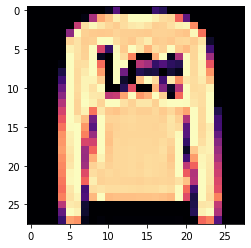

In [14]:
plt.imshow(X_val[1].reshape(28,28), cmap='magma')

In [15]:
# Predict Scores for each class
prediction = nn.predict_scores(X_val[5])[0]


In [16]:
print("Scores")
prediction

Scores


array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])

In [17]:
np.argmax(prediction)

2

In [18]:
predict_class = nn.predict(X_val[0])[0]
predict_class

2

In [19]:
# Original class
y_val[0]

9